In [12]:
%matplotlib inline
import scipy.stats as stats
from IPython.core.pylabtools import figsize
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [13]:
#Loss Functions
#A loss function is a function of the true parameter and an estimate of that parameter
#Measures how bad our current estimate is
    #The larger the loss, the worse the estimate is according to loss function
    #We usually want to minimuze the loss function
    #This is exactly what we do in linear regression
    
    #For squared error loss functions, the penalty for being further away
    #from the true parameter increases quadratically and so 
    #the loss for outlier events is large
    #Thus, Squared  Error loss imposes a cost such that large errors are very bad
    
    #One way to fix this is absolute loss which takes the absolute
    #value between the difference of our estimate and the true parameter
    
    #Traditionaly loss functions have been about minimizing error estimates
    #Another way to think about them is understanding the outcomes of errors 
    #and associated costs
    
#Bayesian approach to Loss Functions
#If we knew the true parameter, there would not be a need for an estimate
#In Bayes-Land, unknown values are random variables with prior and posterior distributions
#Within the posterior distribution, a single value drawn from the distribution
#is simply one possible realization of the what the true parameter could be
#And because we have a distribution of the unknown parameter, our expected value
#is actually an expected loss value. We should compute the expected loss as a function of the
#posterior istribution rather than the expected loss from any single point within the posterior distribution

#To do this we give a Bayesian Point Estimate


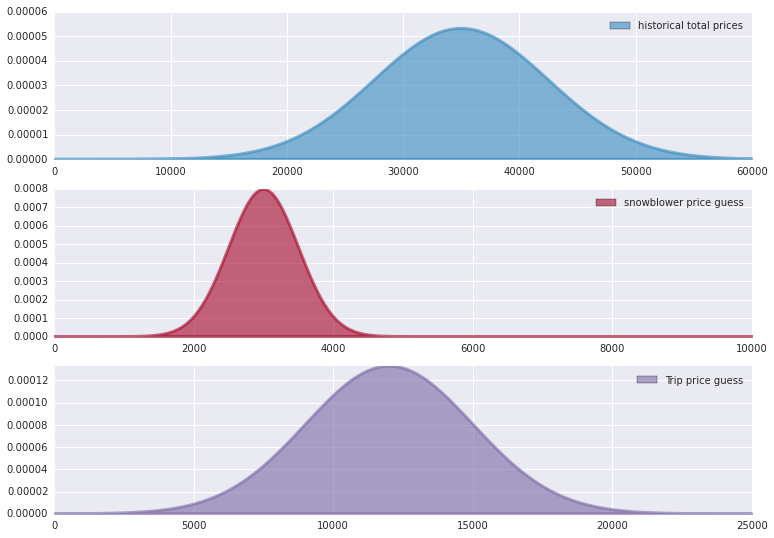

In [14]:
figsize(12.5, 9)

norm_pdf = stats.norm.pdf

plt.subplot(311)
x = np.linspace(0, 60000, 200)
sp1 = plt.fill_between(x, 0, norm_pdf(x, 35000, 7500),
                      color="#348ABD", lw=3, alpha=0.6,
                      label="historical total prices")
p1 = plt.Rectangle((0,0), 1, 1, fc=sp1.get_facecolor()[0])
plt.legend([p1], [sp1.get_label()])

plt.subplot(312)
x = np.linspace(0, 10000, 200)
sp2 = plt.fill_between(x, 0, norm_pdf(x, 3000, 500),
                      color="#A60628", lw=3, alpha=0.6,
                      label="snowblower price guess")

p2 = plt.Rectangle((0,0), 1, 1, fc=sp2.get_facecolor()[0])
plt.legend([p2], [sp2.get_label()])

plt.subplot(313)
x = np.linspace(0, 25000, 200)
sp3 = plt.fill_between(x, 0, norm_pdf(x, 12000, 3000),
                      color="#7A68A6", lw=3, alpha=0.6,
                      label="Trip price guess")
plt.autoscale(tight=True)
p3 = plt.Rectangle((0,0), 1, 1,fc=sp3.get_facecolor()[0])
plt.legend([p3], [sp3.get_label()])

In [15]:
import pymc as pm

#These are our estimates for the prices of the goods and std
data_mu= [3e3, 12e3]
data_std = [5e2, 3e3]

#this is our prior knowledge of the price of previous goods
mu_prior = 35e3
std_prior = 75e2

true_price = pm.Normal("true_price", mu_prior, 1.0 / std_prior**2)

prize_1 = pm.Normal("first_prize", data_mu[0], 1.0 / data_std[0]**2)
prize_2 = pm.Normal("second-prize", data_mu[1], 1.0 / data_std[1]**2)

price_estimate = prize_1 + prize_2

@pm.potential
def error(true_price=true_price, price_estimate=price_estimate):
    return pm.normal_like(true_price, price_estimate, 1 / (3e3)**2)

mcmc = pm.MCMC([true_price, prize_1, prize_2, price_estimate, error])
mcmc.sample(50000,10000)

price_trace = mcmc.trace("true_price")[:]

Couldn't import dot_parser, loading of dot files will not be possible.
 [-----------------100%-----------------] 50000 of 50000 complete in 7.9 sec

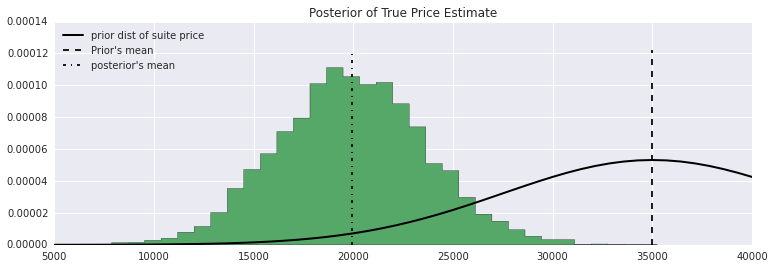

In [21]:
figsize(12.5, 4)

import scipy.stats as stats

x = np.linspace(5000, 40000)
plt.plot(x, stats.norm.pdf(x, 35000, 7500), c='k', lw=2,
        label="prior dist of suite price")

_hist = plt.hist(price_trace, bins=35, normed=True, histtype="stepfilled")
plt.title("Posterior of True Price Estimate")
plt.vlines(mu_prior, 0, 1.1*np.max(_hist[0]), label="Prior's mean",
          linestyles='--')
plt.vlines(price_trace.mean(), 0, 1.1*np.max(_hist[0]),
          label="posterior's mean", linestyles="-.")
plt.legend(loc="upper left")

(5000, 30000)

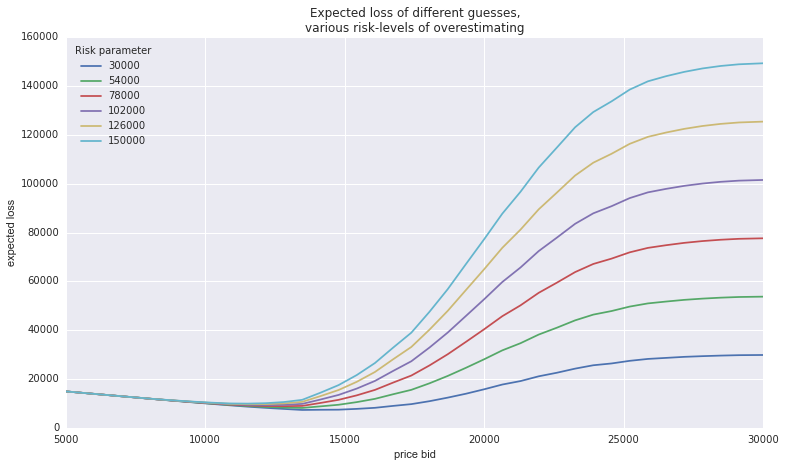

In [29]:
figsize(12.5, 7)

def showdown_loss(guess, true_price, risk=80000):
    loss = np.zeros_like(true_price)
    ix = true_price < guess
    #print ix
    loss[~ix] = np.abs(guess - true_price[~ix])
    #print loss[~ix]
    close_mask = [abs(true_price - guess) <= 250]
    loss[close_mask] = -2*true_price[close_mask]
    loss[ix] = risk
    return loss

guesses = np.linspace(5000,50000,70)
risks = np.linspace(30000, 150000,6)

#This is our point estimate
expected_loss = lambda guess, risk: \
    showdown_loss(guess, price_trace, risk).mean()
    
for _p in risks:
    results = [expected_loss(_g, _p) for _g in guesses]
    plt.plot(guesses, results, label="%d" % _p)
    
plt.title("Expected loss of different guesses, \nvarious risk-levels of overestimating")
plt.legend(loc="upper left", title="Risk parameter")
plt.xlabel("price bid")
plt.ylabel("expected loss")
plt.xlim(5000, 30000);
    

minimum at risk 30000: 13916.05
minimum at risk 54000: 13529.81
minimum at risk 78000: 12405.54
minimum at risk 102000: 12395.40
minimum at risk 126000: 12272.93
minimum at risk 150000: 11132.32


(-1000, 80000)

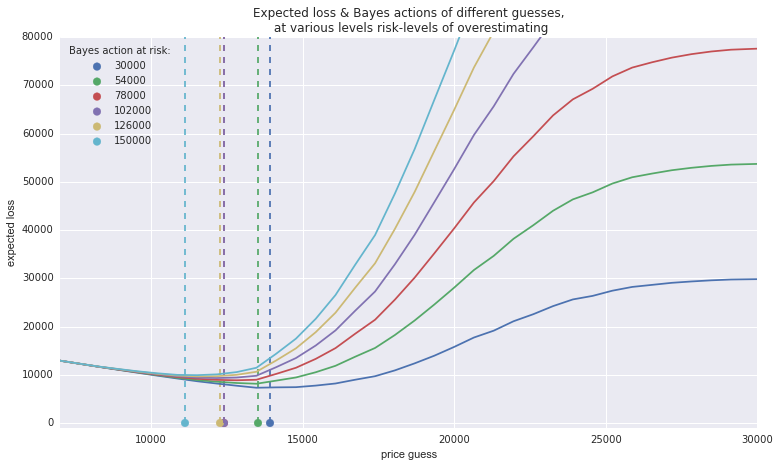

In [32]:
#Minimizing Loss

#The minimum of expected loss is called the Bayes action
#Scipy allows us to solve for Bayes action by using optimization routines

import scipy.optimize as sop

ax = plt.subplot(111)

for _p in risks:
    _color = ax._get_lines.color_cycle.next()
    _min_results = sop.fmin(expected_loss, 15000, args=(_p,), disp=False)
    _results = [expected_loss(_g,_p) for _g in guesses]
    plt.plot(guesses, _results, color=_color)
    plt.scatter(_min_results, 0, s=60,
               color=_color, label="%d" %_p)
    plt.vlines(_min_results, 0, 120000, color=_color, linestyles='--')
    print "minimum at risk %d: %.2f" % (_p, _min_results)
    

plt.title("Expected loss & Bayes actions of different guesses, \n at various levels risk-levels of overestimating")
plt.legend(loc="upper left", scatterpoints=1, title="Bayes action at risk:")
plt.xlabel("price guess")
plt.ylabel("expected loss")
plt.xlim(7000,30000)
plt.ylim(-1000,80000)


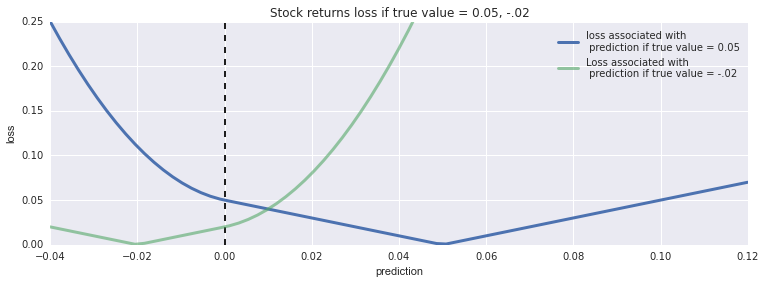

In [35]:
#Finding Bayes actions is equivalent to finding parameters that optimize
#an arbitrary performance measure, rather than parameter accuracy


#We need a loss function that takes into account the sign of 
#prediction and true value
figsize(12.5, 4)

def stock_loss(true_return, yhat, alpha=100.):
    if true_return *yhat < 0:
        return alpha*yhat**2 - np.sign(true_return)*yhat + abs(true_return)
    else:
        return abs(true_return - yhat)
    
true_value = .05
prediction = np.linspace(-.04, .12, 75)

plt.plot(prediction, [stock_loss(true_value, _p) for _p in prediction],
        label="loss associated with \n prediction if true value = 0.05", lw=3)

plt.vlines(0,0,.25, linestyles='--')
plt.xlabel("prediction")
plt.ylabel("loss")
plt.xlim(-.04, .12)
plt.ylim(0, 0.25)

true_value = -.02
plt.plot(prediction, [stock_loss(true_value, _p) for _p in prediction], alpha=0.6,
        label="Loss associated with \n prediction if true value = -.02", lw=3)

plt.legend()
plt.title("Stock returns loss if true value = 0.05, -.02")
    

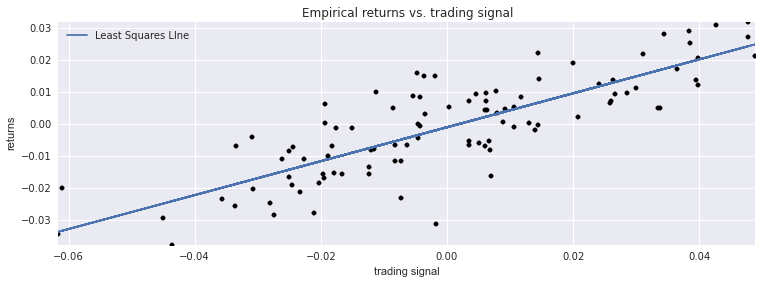

In [36]:
#Generate bogus data
N = 100
X = .025 * np.random.randn(N)
Y = 0.5 * X + 0.01 * np.random.randn(N)

ls_coef_ = np.cov(X, Y)[0,1] / np.var(X)
ls_intercept = Y.mean() - ls_coef_ * X.mean()

plt.scatter(X, Y, c='k')
plt.xlabel('trading signal')
plt.ylabel('returns')
plt.title("Empirical returns vs. trading signal")
plt.plot(X, ls_coef_*X + ls_intercept, label="Least Squares LIne")
plt.xlim(X.min(), X.max())
plt.ylim(Y.min(), Y.max())
plt.legend(loc="upper left");

 [-----------------100%-----------------] 100000 of 100000 complete in 15.1 secPlotting beta
Plotting alpha
Plotting prec


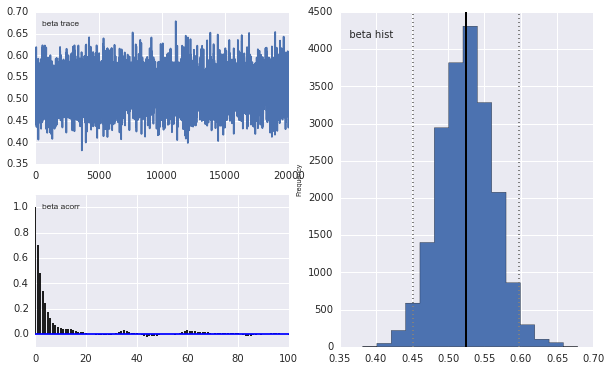

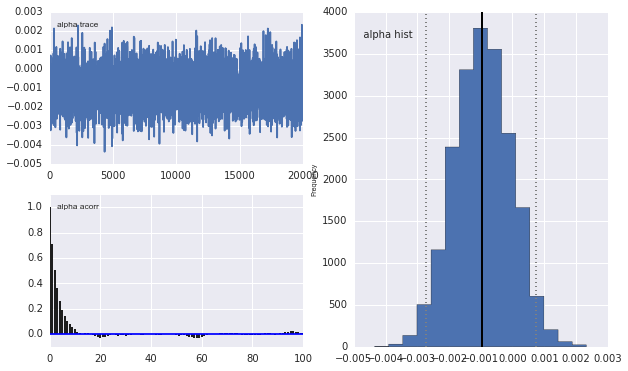

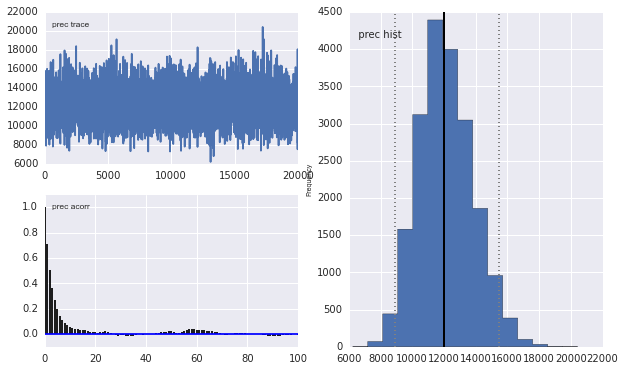

In [37]:
import pymc as pm
from pymc.Matplot import plot as mcplot

std = pm.Uniform("std", 0, 100, trace=False)

@pm.deterministic
def prec(U=std):
    return 1.0 / (U)**2

beta = pm.Normal("beta", 0, 0.0001)
alpha =pm.Normal("alpha", 0, 0.0001)

@pm.deterministic
def mean(X=X, alpha=alpha, beta=beta):
    return alpha + beta *X

obs = pm.Normal("obs", mean, prec, value=Y, observed=True)
mcmc = pm.MCMC([obs, beta, alpha, std, prec])

mcmc.sample(100000,80000)
mcplot(mcmc)

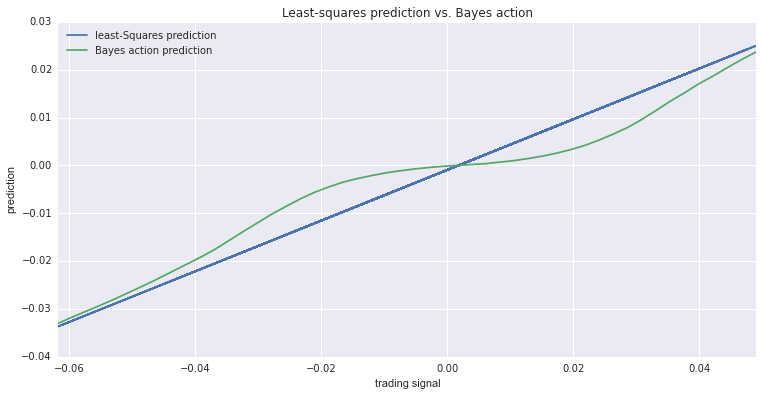

In [41]:
#Plotting Bayes Action over different trading signals

figsize(12.5, 6)
from scipy.optimize import fmin

def stock_loss(price, prediction, coef=500):
    """vectorized for numpy"""
    
    sol = np.zeros_like(price)
    ix = price * prediction < 0
    sol[ix] = coef*prediction **2 - np.sign(price[ix]) * prediction + abs(price[ix]) 
    sol[~ix] = abs(price[~ix] - prediction)
    return sol

tau_samples = mcmc.trace("prec")[:]
alpha_samples = mcmc.trace("alpha")[:]
beta_samples = mcmc.trace("beta")[:]

N = tau_samples.shape[0]

noise = 1. /np.sqrt(tau_samples) * np.random.randn(N)

possible_outcomes = lambda signal: alpha_samples +beta_samples*signal + noise


opt_predictions = np.zeros(50)
trading_signals = np.linspace(X.min(), X.max(), 50)
for i, _signal in enumerate(trading_signals):
    _possible_outcomes = possible_outcomes(_signal)
    tomin = lambda prediction: stock_loss(_possible_outcomes, prediction).mean()
    opt_predictions[i] = fmin(tomin, 0, disp=False)
    

plt.xlabel("trading signal")
plt.ylabel("prediction")
plt.title("Least-squares prediction vs. Bayes action")
plt.plot(X, ls_coef_*X +ls_intercept, label="least-Squares prediction")
plt.xlim(X.min(), X.max())
plt.plot(trading_signals, opt_predictions, label="Bayes action prediction")
plt.legend(loc="upper left");

Data on galaxies in sky 3.
position_x, position_y, e_1, e_2
[[  1.62690000e+02   1.60006000e+03   1.14664000e-01  -1.90326000e-01]
 [  2.27228000e+03   5.40040000e+02   6.23555000e-01   2.14979000e-01]
 [  3.55364000e+03   2.69771000e+03   2.83527000e-01  -3.01870000e-01]]


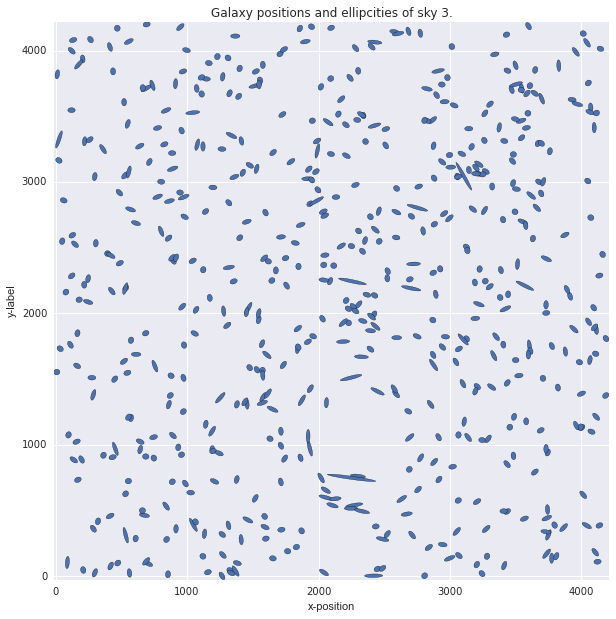

In [44]:
#1. Construct a prior p(x)
#2. Construct a probabilistic model for data given positions of dark matter halos
    #p(e/x)
#3. Use bayes rule to get posterior distribuions of halo positions
#4. Minimize expected loss with respect to posterior distribution vs predictions from prior


from draw_sky2 import draw_sky

n_sky = 3 
data = np.genfromtxt("data/Train_Skies/Train_Skies/Training_Sky%d.csv" % (n_sky),
                                                                          dtype=None,
                                                                          skip_header=1,
                                                                          delimiter=",",
                                                                          usecols=[1,2,3,4])

print "Data on galaxies in sky %d." % (n_sky)
print "position_x, position_y, e_1, e_2"
print data[:3]

fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % (n_sky))
plt.xlabel("x-position")
plt.ylabel("y-label");



In [45]:
#Priors
#Each sky has one, two, or three dark matter halos
#prior distribution is uniform
#x_i ~ Uniform(0, 4200)
#y_i ~ Uniform(0, 4200) i =1,2,3

#distributions of weights of largest halos is log-uniform random
#m_large = mass of large halo
#m_large = logUniform(40,180)

def euclidean_distance(x,y):
    return np.sqrt(((x-y)**2).sum(axis=1))

def f_distance(gxy_pos, halo_pos, c):
    return np.maximum(euclidean_distance(gxy_pos, halo_pos), c)[:,None]


def tangential_distance(glxy_position, halo_position):
    delta = glxy_position - halo_position
    t = (2*np.arctan(delta[:,1] / delta[:,0]))[:,None]
    return np.concatenate([-np.cos(t), -np.sin(t)], axis=1)

import pymc as pm

mass_large = pm.Uniform("mass_large", 40,180, trace=False)
halo_position = pm.Uniform("halo_position", 0, 4200,size =(1,2))

@pm.deterministic
def mean(mass=mass_large, h_pos=halo_position, glx_pos=data[:, :2]):
    return mass / f_distance(glx_pos, h_pos, 240) * tangential_distance(glx_pos, h_pos)



In [47]:
ellpty = pm.Normal("ellipcity", mean, 1. / 0.05, observed=True,
                  value=data[:,2:])
mcmc = pm.MCMC([ellpty, mean, halo_position, mass_large])
map_ = pm.MAP([ellpty,mean, halo_position, mass_large])
map_.fit()
mcmc.sample(200000, 140000, 3)

 [-----------------100%-----------------] 200000 of 200000 complete in 88.5 sec

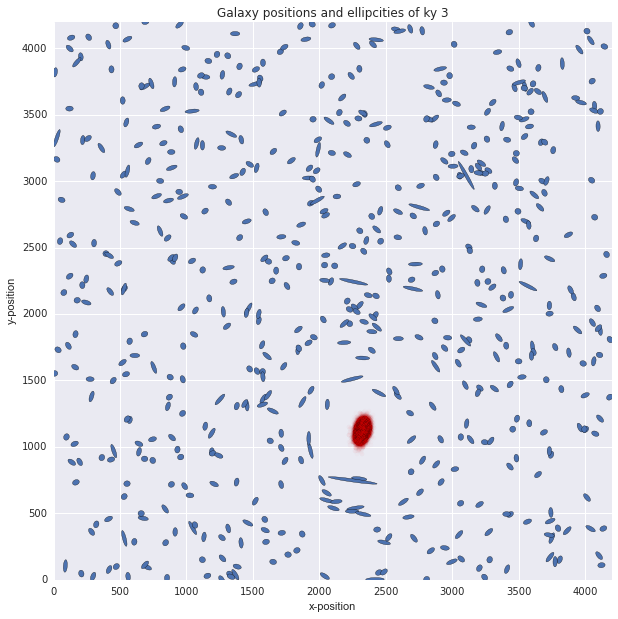

In [48]:
#Lets plot a heatmap of a posterior distribution

t = mcmc.trace("halo_position")[:].reshape(20000, 2)
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of ky %d" % (n_sky))
plt.xlabel("x-position")
plt.ylabel("y-position")
plt.scatter(t[:,0], t[:,1], alpha=0.015, c='r')
plt.xlim(0,4200)
plt.ylim(0,4200);

In [50]:
halo_data = np.genfromtxt("data/Training_halos.csv",
                         delimiter = ",",
                         usecols=[1, 2, 3, 4, 5, 6, 7, 8, 9],
                         skip_header = 1)
print halo_data[n_sky]

[  1.00000000e+00   1.40861000e+03   1.68586000e+03   1.40861000e+03
   1.68586000e+03   0.00000000e+00   0.00000000e+00   0.00000000e+00
   0.00000000e+00]


True halo location: 1408.61 1685.86


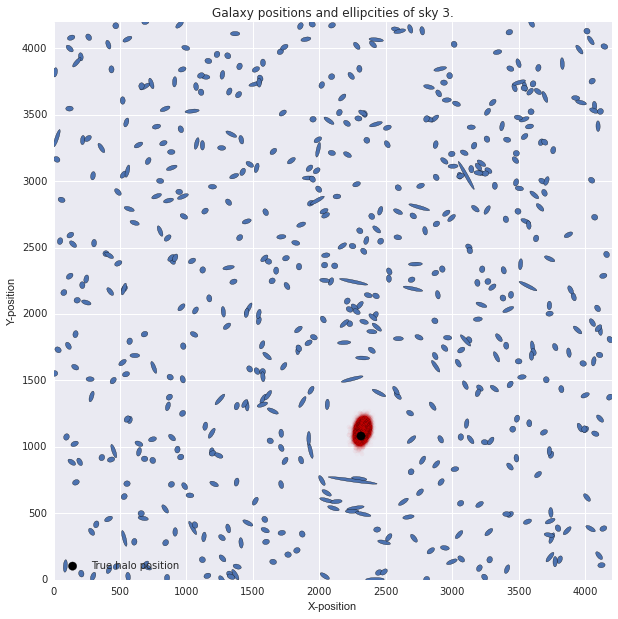

In [51]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d." % (n_sky))
plt.xlabel("X-position")
plt.ylabel("Y-position")
plt.scatter(t[:,0], t[:,1], alpha=0.015, c='r')
plt.scatter(halo_data[n_sky -1][3], halo_data[n_sky -1][4], 
           label="True halo position",
           c="k", s=70)
plt.legend(scatterpoints=1, loc="lower left")
plt.xlim(0, 4200)
plt.ylim(0, 4200)

print "True halo location:", halo_data[n_sky][3], halo_data[n_sky][4]

In [52]:
mean_posterior = t.mean(axis=0).reshape(1,2)
print mean_posterior

[[ 2324.03978407  1123.29182085]]


In [54]:
from DarkWorldsMetric import main_score

_halo_data = halo_data[n_sky -1]

nhalo_all = _halo_data[0].reshape(1,1)
x_true_all = _halo_data[3].reshape(1,1)
y_true_all = _halo_data[4].reshape(1,1)
x_ref_all = _halo_data[1].reshape(1,1)
y_ref_all = _halo_data[2].reshape(1,1)
sky_prediction = mean_posterior

print "Using the mean:"
main_score(nhalo_all, x_true_all, y_true_all, x_ref_all, y_ref_all, sky_prediction)

print

random_guess = np.random.randint(0, 4200, size=(1,2))
print "Using a random location:", random_guess
main_score(nhalo_all, x_true_all,y_true_all,x_ref_all,y_ref_all, random_guess)

print

Using the mean:
Your average distance in pixels you are away from the true halo is 42.1588683877
Your average angular vector is 1.0
Your score for the training data is 1.04215886839

Using a random location: [[   6 1216]]
Your average distance in pixels you are away from the true halo is 2313.66658162
Your average angular vector is 1.0
Your score for the training data is 3.31366658162



In [70]:
from pymc.Matplot import plot as mcplot


def halo_posteriors(n_halos_in_sky, galaxy_data,
                    samples=5e5, burn_in=34e4, thin=4):
    # set the size of the halo's mass
    """
    exp_mass_large = pm.Uniform("exp_mass_large", 40, 180)
    @pm.deterministic
    def mass_large(exp_mass_large = exp_mass_large):
        return np.log(exp_mass_large)
    """

    mass_large = pm.Uniform("mass_large", 40, 180)

    mass_small_1 = 20
    mass_small_2 = 20

    masses = np.array([mass_large, mass_small_1, mass_small_2], dtype=object)

    # set the initial prior positions of the halos, it's a 2-d Uniform dist.
    halo_positions = pm.Uniform("halo_positions", 0, 4200,
                                size=(n_halos_in_sky, 2))  # notice this size

    fdist_constants = np.array([240, 70, 70])

    @pm.deterministic
    def mean(mass=masses, h_pos=halo_positions, glx_pos=data[:, :2],
             n_halos_in_sky=n_halos_in_sky):

        _sum = 0
        for i in range(n_halos_in_sky):
            _sum += mass[i] / f_distance(glx_pos, h_pos[i, :], fdist_constants[i]) *\
                tangential_distance(glx_pos, h_pos[i, :])

        return _sum

    ellpty = pm.Normal("ellipcity", mean, 1. / 0.05, observed=True,
                       value=data[:, 2:])

    map_ = pm.MAP([ellpty, mean, halo_positions, mass_large])
    map_.fit(method="fmin_powell")

    mcmc = pm.MCMC([ellpty, mean, halo_positions, mass_large])
    mcmc.sample(samples, burn_in, thin)
    return mcmc.trace("halo_positions")[:]

In [71]:
n_sky = 215
data = np.genfromtxt("data/Train_Skies/Train_Skies/Training_sky%d.csv" % 
                    (n_sky), 
                     dtype=None, 
                     skip_header=1, 
                     delimiter=",", 
                     usecols= [1,2,3,4])


In [72]:
samples = 10.5e5
traces = halo_posteriors(3, data, samples=samples,
                        burn_in = 9.5e5, 
                        thin=10)


 [-----------------100%-----------------] 1050000 of 1050000 complete in 798.0 sec

(0, 4200)

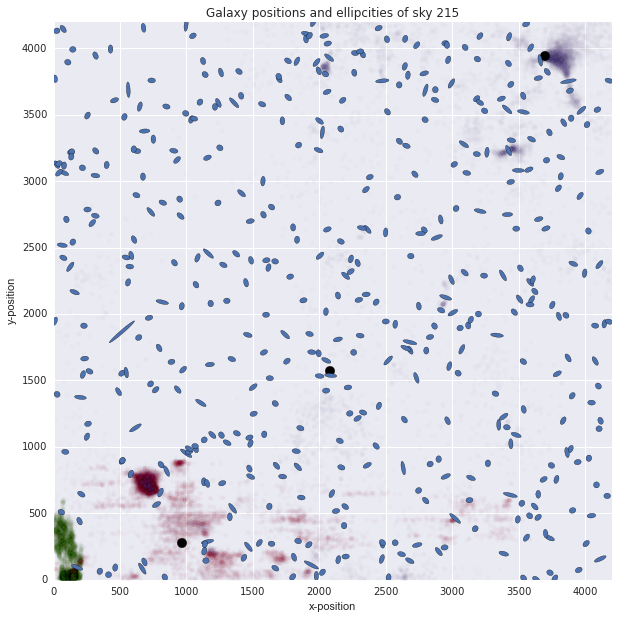

In [74]:
fig = draw_sky(data)
plt.title("Galaxy positions and ellipcities of sky %d" % n_sky)
plt.xlabel("x-position")
plt.ylabel("y-position")

colors = ["#467821", "#A60628", "#7A68A6"]

for i in range(traces.shape[1]):
    plt.scatter(traces[:, i, 0], traces[:,i,1], c=colors[i], alpha=0.02)
    
for i in range(traces.shape[1]):
    plt.scatter(halo_data[n_sky -1][3+2*i], halo_data[n_sky -1][4+2*i],
               label="True halo position",
               c='k', s=90)
    
plt.xlim(0,4200)
plt.ylim(0,4200)

In [75]:
_halo_data = halo_data[n_sky -1]
print traces.shape

mean_posterior = traces.mean(axis=0).reshape(1,6)
print mean_posterior

nhalo_all = _halo_data[0].reshape(1,1)
x_true_all = _halo_data[3].reshape(1,1)
y_true_all = _halo_data[4].reshape(1,1)
x_ref_all = _halo_data[1].reshape(1,1)
y_ref_all = _halo_data[2].reshape(1,1)
sky_predicition = mean_posterior

print "Using Mean:"
main_score([1], x_true_all, y_true_all, x_ref_all, y_ref_all, sky_prediction)

print
random_guess = np.random.randint(0, 4200, size=(1,2))
print "Using a random location"
main_score([1], x_true_all, y_true_all, x_ref_all, y_ref_all, random_guess)

print

(10000, 3, 2)
[[  109.25363121   142.24390738  1053.35086988   532.76702299
   2753.34660579  2666.29232836]]
Using Mean:
Your average distance in pixels you are away from the true halo is 3135.0864861
Your average angular vector is 1.0
Your score for the training data is 4.1350864861

Using a random location
Your average distance in pixels you are away from the true halo is 1377.87847595
Your average angular vector is 1.0
Your score for the training data is 2.37787847595

